In [1]:
import xobjects as xo
import xpart as xp
import xcoll as xc
import numpy as np
import xtrack as xt
import pickle

import matplotlib.pyplot as plt
from scipy.stats import *
from madxtools.particles import *

import sys
import os
current_working_directory = os.getcwd()
module_directory = os.path.join(current_working_directory, '..')
absolute_module_directory = os.path.abspath(module_directory)
sys.path.append(absolute_module_directory)
from t07_functions import *

from scipy.stats import pearsonr, spearmanr, kendalltau

In [110]:
num_part = 5000
p, exn, eyn, betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, ex, ey, sige = calc_initial_condition(0.5)

# Make a transfer line
# ====================
k_qf_1 = 0.32730047
k_qd_2 = -0.36102915
k_qf_3 = 0.32789126
k_qd_4 = -0.1991137
l_quad = 2

elements = [
            xt.Quadrupole(k1=k_qf_1, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qd_2, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qf_3, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qd_4, length=l_quad),
            xt.Drift(length=89.),
            xt.Marker(),
           ]
element_names = ["QF1", "drift_1", "QD2", "drift_2", "QF3", "drift_3", "QD4",
                 "drift_4", "END"]
particle_ref = xp.Particles(energy0=p*1e9)
line = xt.Line(elements=elements, element_names=element_names, particle_ref=particle_ref)

# Add octupoles

oct1 = xt.Multipole(order=3, knl=[0,0,0,40], length=0.5)
line.insert_element(element=oct1, name="oct1", at_s=40)
q1 = xt.Quadrupole(k1=0.5, length=0.402)
line.insert_element(element=q1, name="q1", at_s=42)

oct2 = xt.Multipole(order=3, knl=[0,0,0,40], length=0.5)
line.insert_element(element=oct2, name="oct2", at_s=58)
q2 = xt.Quadrupole(k1=0.5, length=0.402)
line.insert_element(element=q2, name="q2", at_s=60)


# Generate an initial distribution of particles
# =============================================
line.build_tracker(_context=xo.ContextCpu())

4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.


In [111]:
line.vars['k_qf1'] = 0.5
line.element_refs['QF1'].k1 = line.vars['k_qf1']

In [112]:
line.vars['k_qf1'] = 0.6

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


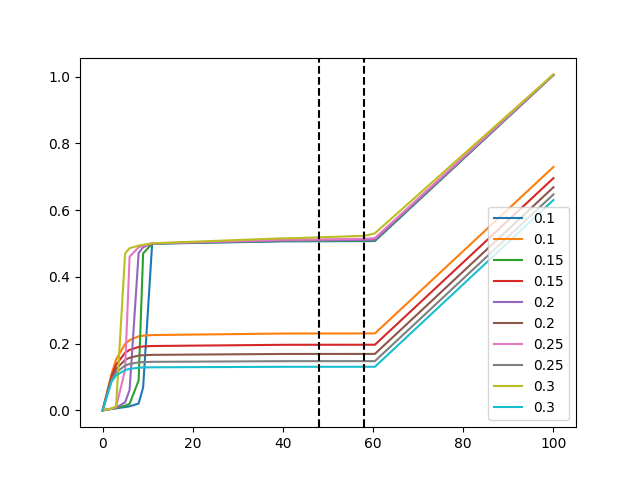

In [124]:
tw_init = xt.TwissInit(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, dx=dx0, dy=dy0, dpx=dpx0, dpy=dpy0)
tw = line.twiss(method='6d', start="QF1", end="END", init=tw_init)
tw_df = tw.to_pandas()
tw_df[tw_df.name == 'oct2'].mux.iloc[0] - tw_df[tw_df.name == 'oct1'].mux.iloc[0]

fig, ax = plt.subplots()

for i in np.linspace(0.1, 0.3, 5):
    line.vars['k_qf1'] = i
    tw = line.twiss(method='6d', start="QF1", end="END", init=tw_init)
    tw_df = tw.to_pandas()
    ax.plot(tw_df.s, tw_df.mux, label=f"{i}")
    ax.plot(tw_df.s, tw_df.muy, label=f"{i}")
ax.legend()
ax.axvline(48, ls="--", c="k")
ax.axvline(58, ls="--", c="k")

In [114]:
tw_init = xt.TwissInit(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, dx=dx0, dy=dy0, dpx=dpx0, dpy=dpy0)
tw = line.twiss(method='6d', start="QF1", end="END", init=tw_init, )

nemitt_x = exn
nemitt_y = eyn
x_norm, px_norm = xp.generate_2D_gaussian(num_part)
y_norm, py_norm = xp.generate_2D_gaussian(num_part)

part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                            W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                            nemitt_x=nemitt_x,nemitt_y=nemitt_y)
part._init_random_number_generator()

Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


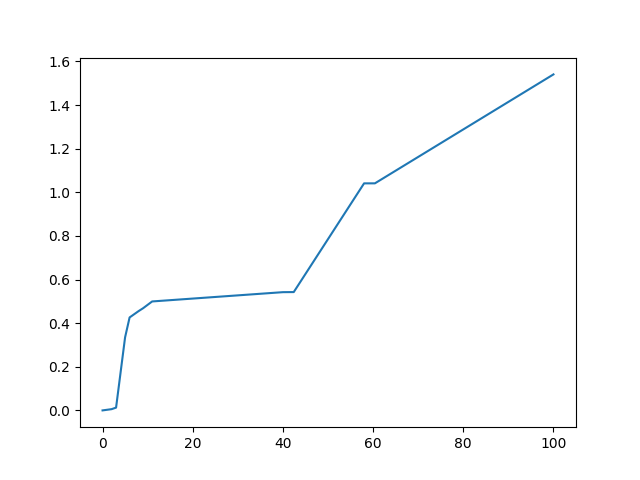

In [115]:
fig, ax = plt.subplots()
ax.plot(tw_df.s, tw_df.mux)

In [116]:
line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

Found suitable prebuilt kernel `default_only_xtrack`.


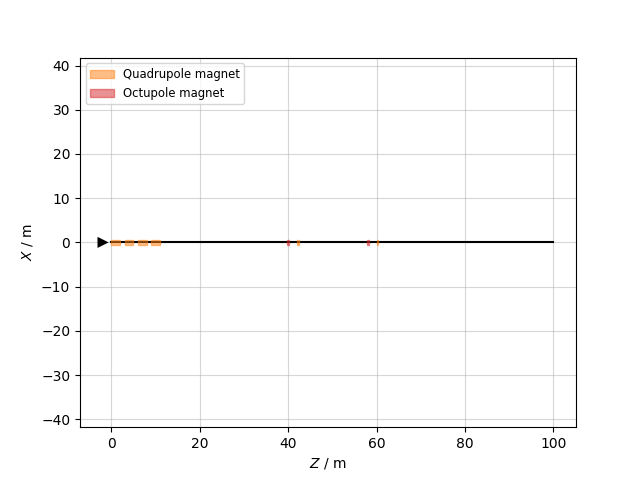

In [117]:
line.discard_tracker()
line['q2'].s = 85
line.build_tracker()

# Compute survey
sv = line.survey()
# Plot ring geometry using Xplt (credits P. Niedermayer)
import xplt
xplt.FloorPlot(sv, line)
plt.legend(fontsize='small', loc='upper left')

In [118]:
line['q1'].k1 = 0.2
line['q2'].k1 = -0.2
# Loop through the tracking
part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                            W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                            nemitt_x=nemitt_x,nemitt_y=nemitt_y)
part._init_random_number_generator()
line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

Text(0.5, 1.0, 's = 100.0 m')

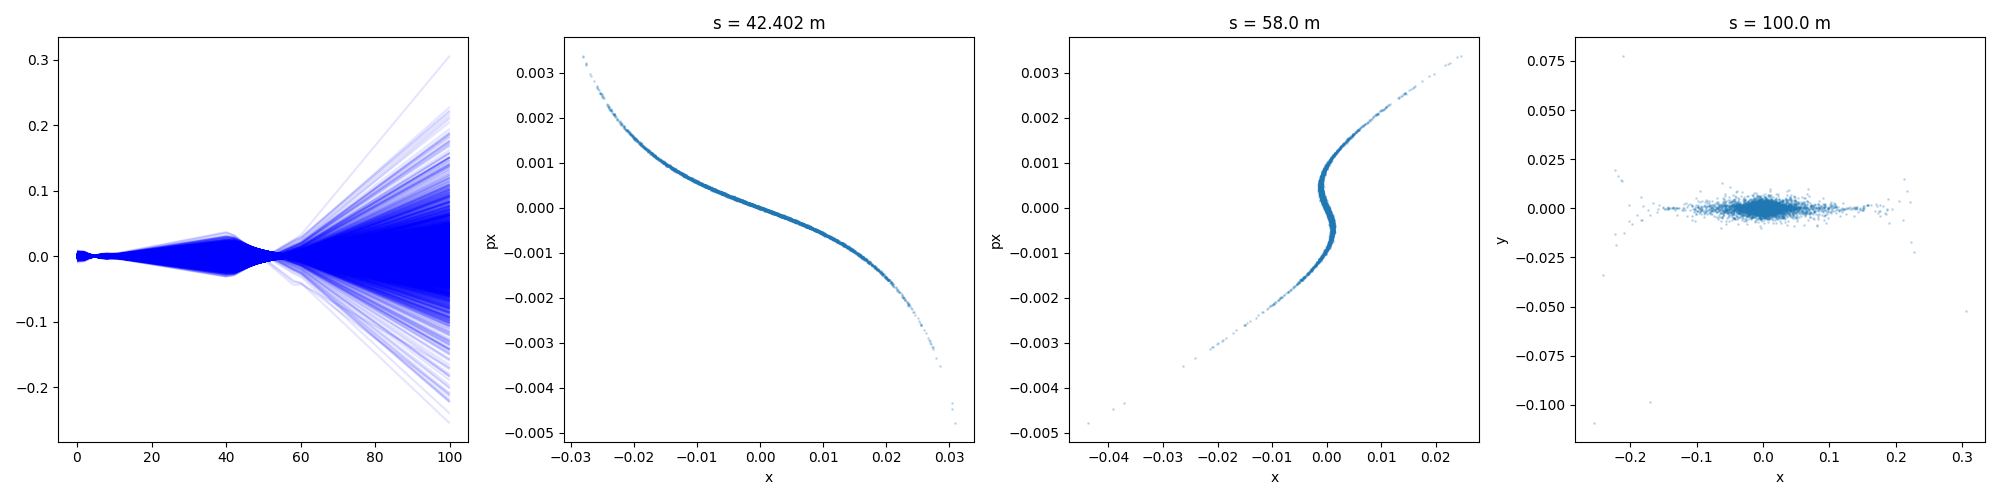

In [119]:
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt

# Change and track
line['q1'].k1 = 0.2
line['q2'].k1 = -0.2
line['oct1'].knl = [0,0,0,400]
line['oct2'].knl = [0,0,0,400]
# Loop through the tracking
part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                            W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                            nemitt_x=nemitt_x,nemitt_y=nemitt_y)
part._init_random_number_generator()
line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

## Plot
fig, ax = plt.subplots(1,4, figsize=(20, 5), tight_layout=True)

# Create a collection of lines
lines = [list(zip(line.record_last_track.s[i], line.record_last_track.x[i])) for i in range(len(line.record_last_track.s))]
line_collection = LineCollection(lines, colors='blue', alpha=0.1)
ax[0].add_collection(line_collection)

# Set limits and labels
ax[0].autoscale()

# First octupoles
target_s = 49
s_array = line.record_last_track.s[0]
differences = np.abs(s_array - target_s)
s_index = np.argmin(differences)

x = line.record_last_track.x[:,s_index]
px = line.record_last_track.px[:,s_index]
ax[1].scatter(x, px, alpha=0.2, s=1)
ax[1].set_xlabel("x")
ax[1].set_ylabel("px")
ax[1].set_title(f"s = {s_array[s_index]} m")

target_s = 59
s_array = line.record_last_track.s[0]
differences = np.abs(s_array - target_s)
s_index = np.argmin(differences)

x = line.record_last_track.x[:,s_index]
px = line.record_last_track.px[:,s_index]
ax[2].scatter(x, px, alpha=0.2, s=1)
ax[2].set_xlabel("x")
ax[2].set_ylabel("px")
ax[2].set_title(f"s = {s_array[s_index]} m")


target_s = 100
s_array = line.record_last_track.s[0]
differences = np.abs(s_array - target_s)
s_index = np.argmin(differences)

x = line.record_last_track.x[:,s_index]
px = line.record_last_track.y[:,s_index]
ax[3].scatter(x, px, alpha=0.2, s=1)
ax[3].set_xlabel("x")
ax[3].set_ylabel("y")
ax[3].set_title(f"s = {s_array[s_index]} m")


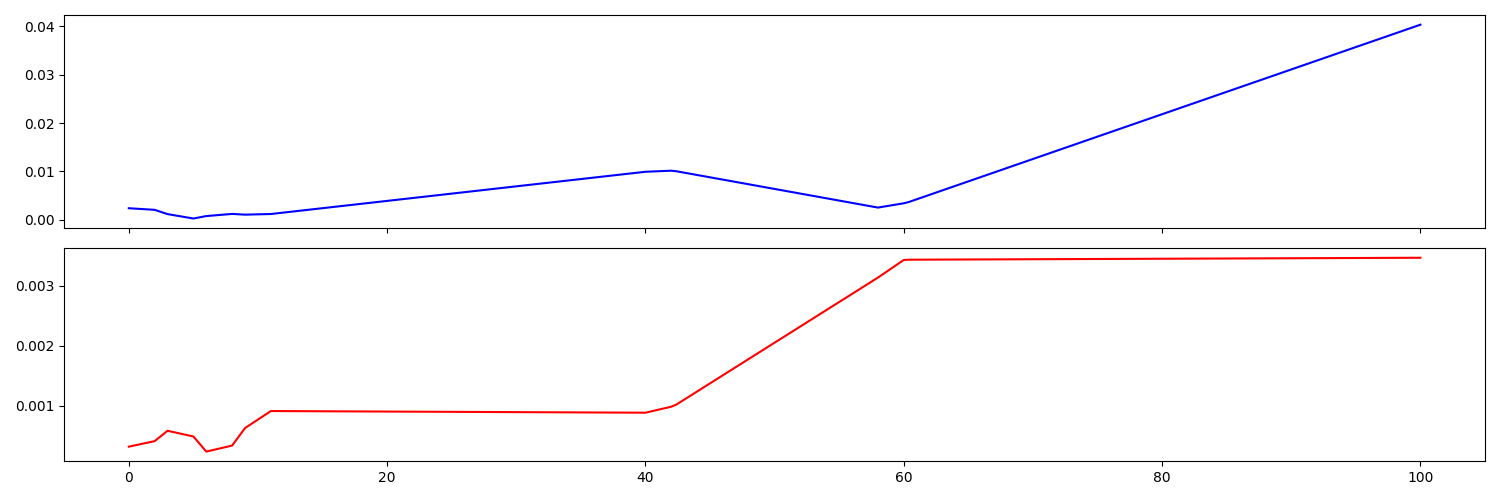

In [120]:
fig,ax = plt.subplots(2,1, figsize=(15,5), tight_layout=True, sharex=True)

s_list = []
sigH_list = []
sigV_list = []

for i in range(len(tw.s)):
    s_list.append(tw.s[i])
    sigH_list.append(np.std(line.record_last_track.x[:,i]))
    sigV_list.append(np.std(line.record_last_track.y[:,i]))
ax[0].plot(s_list, sigH_list, c="b")
ax[1].plot(s_list, sigV_list, c="r")

import pandas as pd
d = {'s': s_list, 'sigH': sigH_list, 'sigV': sigV_list}
df = pd.DataFrame(data=d)

# Play with sliders

In [121]:
from ipywidgets import interact, FloatSlider, Output, widgets, Layout, HBox

Output(layout=Layout(height='auto', width='70%'))

Output(layout=Layout(height='auto', width='70%'))

Output(layout=Layout(height='auto', width='70%'))

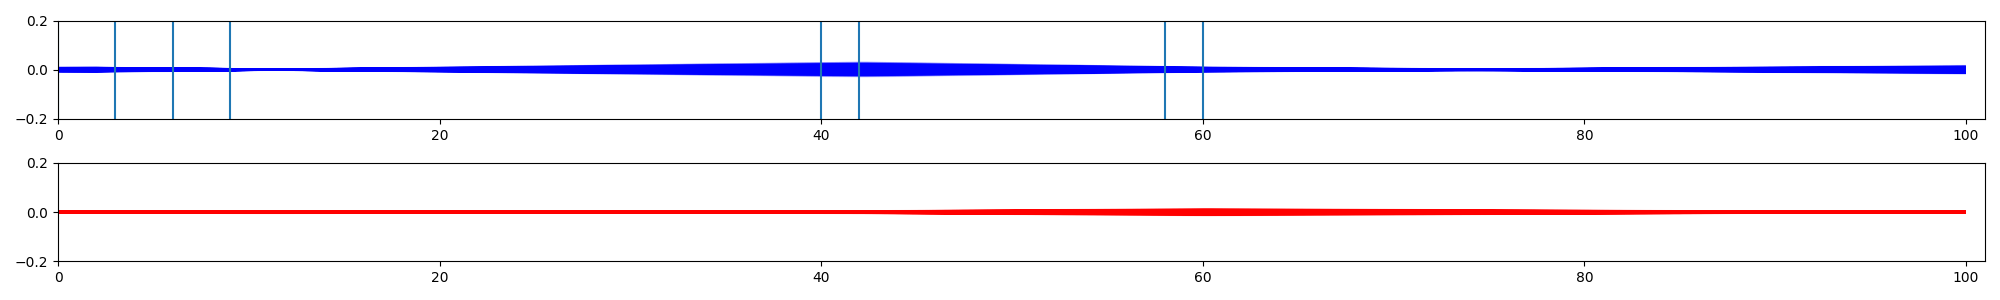

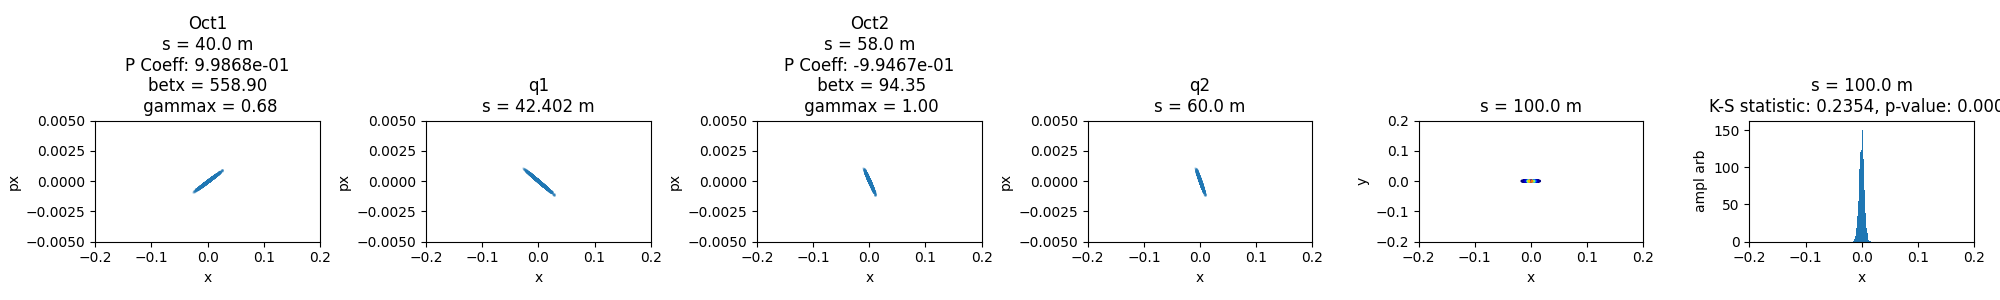

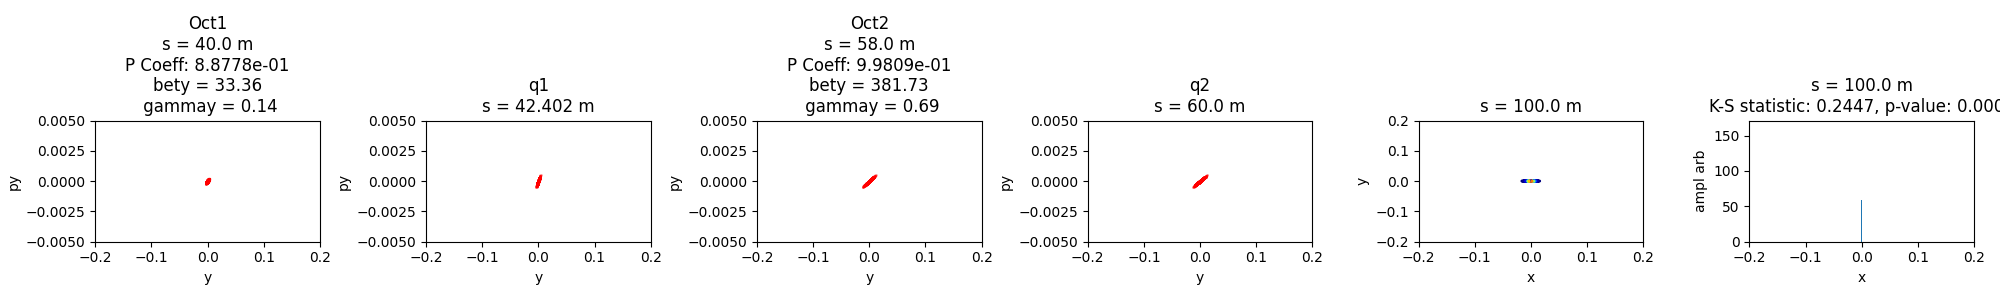

In [122]:
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
%matplotlib widget

def update_and_plot(change):
    # Change and track
    line['QF1'].k1 = k_QF1.value
    line['QD2'].k1 = k_QD2.value
    line['QF3'].k1 = k_QF3.value
    line['QD4'].k1 = k_QD4.value
    line['q1'].k1 = q1.value
    line['q2'].k1 = q2.value
    line['oct1'].knl = [0,0,0,oct1.value]
    line['oct1'].ksl = [0,0,0,0]
    line['oct2'].knl = [0,0,0,oct2.value]
    line['oct2'].ksl = [0,0,0,0]
    
    # Loop through the tracking
    x_norm, px_norm = xp.generate_2D_gaussian(num_part)
    y_norm, py_norm = xp.generate_2D_gaussian(num_part)
    part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                                W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                                nemitt_x=nemitt_x,nemitt_y=nemitt_y)
    part._init_random_number_generator()
    line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")
    line_df = line.to_pandas()

    with Output1:
        ax[0].clear()
        ax[1].clear()

        lines = [list(zip(line.record_last_track.s[i], line.record_last_track.x[i])) for i in range(len(line.record_last_track.s))]
        line_collection = LineCollection(lines, colors='blue', alpha=0.1)
        ax[0].add_collection(line_collection)
        ax[0].set_ylim(-0.2, 0.2)
        ax[0].set_xlim(0, 101)

        lines = [list(zip(line.record_last_track.s[i], line.record_last_track.y[i])) for i in range(len(line.record_last_track.s))]
        line_collection = LineCollection(lines, colors='red', alpha=0.1)
        ax[1].add_collection(line_collection)
        ax[1].set_ylim(-0.2, 0.2)
        ax[1].set_xlim(0, 101)

        ax[0].axvline(line_df[line_df.name == 'QF1'].s.iloc[0])
        ax[0].axvline(line_df[line_df.name == 'QD2'].s.iloc[0])
        ax[0].axvline(line_df[line_df.name == 'QF3'].s.iloc[0])
        ax[0].axvline(line_df[line_df.name == 'QD4'].s.iloc[0])

        ax[0].axvline(line_df[line_df.name == 'oct1'].s.iloc[0])
        ax[0].axvline(line_df[line_df.name == 'q1'].s.iloc[0])
        ax[0].axvline(line_df[line_df.name == 'oct2'].s.iloc[0])
        ax[0].axvline(line_df[line_df.name == 'q2'].s.iloc[0])


    with Output2:
        ax2[0].clear()
        ax2[1].clear()
        ax2[2].clear()
        ax2[3].clear()
        ax2[4].clear()
        ax2[5].clear()

        # First octupoles
        target_s = line_df[line_df.name == 'oct1'].s.iloc[0]
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        x = line.record_last_track.x[:,s_index]
        px = line.record_last_track.px[:,s_index]

        pearson_coeff, p_value = pearsonr(x, px)
        betx, alfx, gammax, epsilon = twiss_parameters_from_distribution(x, px)

        ax2[0].scatter(x, px, alpha=0.2, s=1)
        ax2[0].set_xlabel("x")
        ax2[0].set_ylabel("px")
        ax2[0].set_title(f"Oct1\ns = {s_array[s_index]} m\nP Coeff: {pearson_coeff:.4e}\nbetx = {betx:.2f}\n gammax = {gammax:.2f}")
        ax2[0].set_ylim(-5e-3, 5e-3)
        ax2[0].set_xlim(-2e-1, 2e-1)

        # Quadrupole q1
        target_s = 50
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        x = line.record_last_track.x[:,s_index]
        px = line.record_last_track.px[:,s_index]

        ax2[1].scatter(x, px, alpha=0.2, s=1)
        ax2[1].set_xlabel("x")
        ax2[1].set_ylabel("px")
        ax2[1].set_title(f"q1\ns = {s_array[s_index]} m")
        ax2[1].set_ylim(-5e-3, 5e-3)
        ax2[1].set_xlim(-2e-1, 2e-1)
        
        # Second octupoles
        target_s = line_df[line_df.name == 'oct2'].s.iloc[0]
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        x = line.record_last_track.x[:,s_index]
        px = line.record_last_track.px[:,s_index]

        pearson_coeff, p_value = pearsonr(x, px)
        betx, alfx, gammax, epsilon = twiss_parameters_from_distribution(x, px)

        ax2[2].scatter(x, px, alpha=0.2, s=1)
        ax2[2].set_xlabel("x")
        ax2[2].set_ylabel("px")
        ax2[2].set_title(f"Oct2\ns = {s_array[s_index]} m\nP Coeff: {pearson_coeff:.4e}\n betx = {betx:.2f}\n gammax = {gammax:.2f}")
        ax2[2].set_ylim(-5e-3, 5e-3)
        ax2[2].set_xlim(-2e-1, 2e-1)

        # Quadrupole q2
        target_s = 60
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        x = line.record_last_track.x[:,s_index]
        px = line.record_last_track.px[:,s_index]
        ax2[3].scatter(x, px, alpha=0.2, s=1)
        ax2[3].set_xlabel("x")
        ax2[3].set_ylabel("px")
        ax2[3].set_title(f"q2\ns = {s_array[s_index]} m")
        ax2[3].set_ylim(-5e-3, 5e-3)
        ax2[3].set_xlim(-2e-1, 2e-1)

        # DUT
        target_s = 100
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)
        x = line.record_last_track.x[:,s_index]
        y = line.record_last_track.y[:,s_index]

        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        ax2[4].scatter(x, y, c=z, s=1, cmap="jet")
        ax2[4].set_xlabel("x")
        ax2[4].set_ylabel("y")
        ax2[4].set_title(f"s = {s_array[s_index]} m")
        ax2[4].set_ylim(-0.2, 0.2)
        ax2[4].set_xlim(-0.2, 0.2)

        # Histogram
        target_s = 100
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)
        x = line.record_last_track.x[:,s_index]
        px = line.record_last_track.y[:,s_index]

        data = x
        data_min, data_max = np.min(data), np.max(data)
        uniform_dist = uniform(loc=data_min, scale=data_max-data_min)
        statistic, p_value = kstest(data, uniform_dist.cdf)


        ax2[5].hist(x, bins=100)
        ax2[5].set_xlabel("x")
        ax2[5].set_ylabel("ampl arb")
        ax2[5].set_title(f"s = {s_array[s_index]} m\nK-S statistic: {statistic:.4f}, p-value: {p_value:.4f}")
        ax2[5].set_xlim(-0.2, 0.2)

    with Output3:
        ax3[0].clear()
        ax3[1].clear()
        ax3[2].clear()
        ax3[3].clear()
        ax3[4].clear()
        ax3[5].clear()

        # First octupoles
        target_s = line_df[line_df.name == 'oct1'].s.iloc[0]
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        y = line.record_last_track.y[:,s_index]
        py = line.record_last_track.py[:,s_index]

        pearson_coeff, p_value = pearsonr(y, py)
        bety, alfy, gammay, epsilon = twiss_parameters_from_distribution(y, py)

        ax3[0].scatter(y, py, alpha=0.2, s=1, c="r")
        ax3[0].set_xlabel("y")
        ax3[0].set_ylabel("py")
        ax3[0].set_title(f"Oct1\ns = {s_array[s_index]} m\nP Coeff: {pearson_coeff:.4e}\nbety = {bety:.2f}\n gammay = {gammay:.2f}")
        ax3[0].set_ylim(-5e-3, 5e-3)
        ax3[0].set_xlim(-2e-1, 2e-1)

        # Quadrupole q1
        target_s = 50
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        y = line.record_last_track.y[:,s_index]
        py = line.record_last_track.py[:,s_index]

        ax3[1].scatter(y, py, alpha=0.2, s=1, c="r")
        ax3[1].set_xlabel("y")
        ax3[1].set_ylabel("py")
        ax3[1].set_title(f"q1\ns = {s_array[s_index]} m")
        ax3[1].set_ylim(-5e-3, 5e-3)
        ax3[1].set_xlim(-2e-1, 2e-1)
        
        # Second octupoles
        target_s = line_df[line_df.name == 'oct2'].s.iloc[0]
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        y = line.record_last_track.y[:,s_index]
        py = line.record_last_track.py[:,s_index]

        pearson_coeff, p_value = pearsonr(y, py)
        bety, alfy, gammay, epsilon = twiss_parameters_from_distribution(y, py)

        ax3[2].scatter(y, py, alpha=0.2, s=1, c="r")
        ax3[2].set_xlabel("y")
        ax3[2].set_ylabel("py")
        ax3[2].set_title(f"Oct2\ns = {s_array[s_index]} m\nP Coeff: {pearson_coeff:.4e}\nbety = {bety:.2f}\n gammay = {gammay:.2f}")
        ax3[2].set_ylim(-5e-3, 5e-3)
        ax3[2].set_xlim(-2e-1, 2e-1)

        # Quadrupole q2
        target_s = 60
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        y = line.record_last_track.y[:,s_index]
        py = line.record_last_track.py[:,s_index]
        ax3[3].scatter(y, py, alpha=0.2, s=1, c="r")
        ax3[3].set_xlabel("y")
        ax3[3].set_ylabel("py")
        ax3[3].set_title(f"q2\ns = {s_array[s_index]} m")
        ax3[3].set_ylim(-5e-3, 5e-3)
        ax3[3].set_xlim(-2e-1, 2e-1)

        # DUT
        target_s = 100
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)
        x = line.record_last_track.x[:,s_index]
        y = line.record_last_track.y[:,s_index]

        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        ax3[4].scatter(x, y, c=z, s=1, cmap="jet")
        ax3[4].set_xlabel("x")
        ax3[4].set_ylabel("y")
        ax3[4].set_title(f"s = {s_array[s_index]} m")
        ax3[4].set_ylim(-0.2, 0.2)
        ax3[4].set_xlim(-0.2, 0.2)

        # Histogram
        target_s = 100
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)
        y_norm = line.record_last_track.y[:,s_index]

        data = y
        data_min, data_max = np.min(data), np.max(data)
        uniform_dist = uniform(loc=data_min, scale=data_max-data_min)
        statistic, p_value = kstest(data, uniform_dist.cdf)

        ax3[5].hist(y, bins=100)
        ax3[5].set_xlabel("x")
        ax3[5].set_ylabel("ampl arb")
        ax3[5].set_title(f"s = {s_array[s_index]} m\nK-S statistic: {statistic:.4f}, p-value: {p_value:.4f}")
        ax3[5].set_xlim(-0.2, 0.2)

k_QF1 = widgets.FloatSlider(
    value=soln.x[0],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='k_QF1:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

k_QD2 = widgets.FloatSlider(
    value=soln.x[1],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='k_QD2',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

k_QF3 = widgets.FloatSlider(
    value=soln.x[2],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='k_QF3:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

k_QD4 = widgets.FloatSlider(
    value=soln.x[3],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='k_QD4:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

q1 = widgets.FloatSlider(
    value=soln.x[4],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='q1:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

q2 = widgets.FloatSlider(
    value=soln.x[5],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='q2:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

oct1 = widgets.FloatSlider(
    value=0.0,
    min=-600,
    max=600,
    step=0.01,
    description='oct1:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

oct2 = widgets.FloatSlider(
    value=0.0,
    min=-600,
    max=600,
    step=0.01,
    description='oct2:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

Output1 = widgets.Output(layout=Layout(width='70%', height='auto'))
Output2 = widgets.Output(layout=Layout(width='70%', height='auto'))
Output3 = widgets.Output(layout=Layout(width='70%', height='auto'))
display(Output1, Output2, Output3, HBox([k_QF1, k_QD2, k_QF3, k_QD4]), HBox([q1, q2, oct1, oct2]))

with Output1:
    fig, ax = plt.subplots(2,1, figsize=(20, 3), tight_layout=True)

with Output2:
    fig2, ax2 = plt.subplots(1,6, figsize=(20, 3), tight_layout=True)

with Output3:
    fig3, ax3 = plt.subplots(1,6, figsize=(20, 3), tight_layout=True)

k_QF1.observe(update_and_plot, names='value')
k_QD2.observe(update_and_plot, names='value')
k_QF3.observe(update_and_plot, names='value')
k_QD4.observe(update_and_plot, names='value')
q1.observe(update_and_plot, names='value')
q2.observe(update_and_plot, names='value')
oct1.observe(update_and_plot, names='value')
oct2.observe(update_and_plot, names='value')

update_and_plot(change=1)

(-0.2, 0.2)

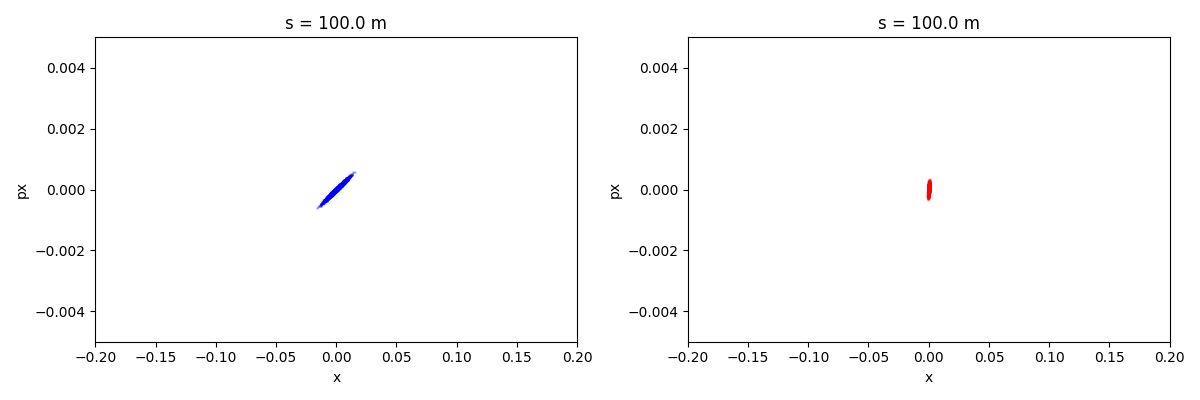

In [123]:
fig, axt = plt.subplots(1,2, tight_layout=True, figsize=(12,4))


target_s = 100
s_array = line.record_last_track.s[0]
differences = np.abs(s_array - target_s)
s_index = np.argmin(differences)

x = line.record_last_track.x[:,s_index]
px = line.record_last_track.px[:,s_index]

axt[0].scatter(x, px, alpha=0.2, s=1, c="b")
axt[0].set_xlabel("x")
axt[0].set_ylabel("px")
axt[0].set_title(f"s = {s_array[s_index]} m")
axt[0].set_ylim(-5e-3, 5e-3)
axt[0].set_xlim(-2e-1, 2e-1)

target_s = 100
s_array = line.record_last_track.s[0]
differences = np.abs(s_array - target_s)
s_index = np.argmin(differences)

y = line.record_last_track.y[:,s_index]
py = line.record_last_track.py[:,s_index]

axt[1].scatter(y, py, alpha=0.2, s=1, c="r")
axt[1].set_xlabel("x")
axt[1].set_ylabel("px")
axt[1].set_title(f"s = {s_array[s_index]} m")
axt[1].set_ylim(-5e-3, 5e-3)
axt[1].set_xlim(-2e-1, 2e-1)

Found suitable prebuilt kernel `default_only_xtrack`.
3.8839853055749884e-05


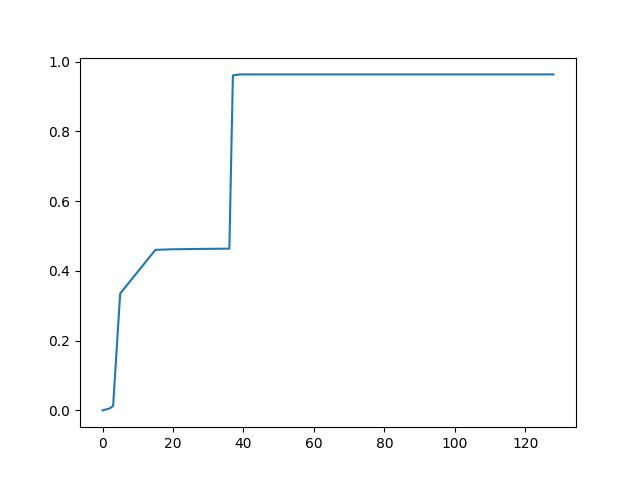

In [17]:
tw_init = xt.TwissInit(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, dx=dx0, dy=dy0, dpx=dpx0, dpy=dpy0)
tw = line.twiss(method='6d', start="QF1", end="END", init=tw_init)
tw_df = tw.to_pandas()
phase_adv = tw_df[tw_df.name == 'oct2'].mux.iloc[0] - tw_df[tw_df.name == 'oct1'].mux.iloc[0]
print(phase_adv)

fig, ax = plt.subplots()
ax.plot(tw_df.s, tw_df.mux)

# Optimize on the high correlation at the octupoles

In [61]:
import scipy.optimize as optimize
import pybobyqa


def optimise(params):

    kQF1, kQD2, kQF3, kQD4, q1, q2 = params
    print(params)

    # Change and track
    line['QF1'].k1 = kQF1
    line['QD2'].k1 = kQD2
    line['QF3'].k1 = kQF3
    line['QD4'].k1 = kQD4
    line['q1'].k1 = q1
    line['q2'].k1 = q2
    line['oct1'].knl = [0,0,0,0]
    line['oct2'].knl = [0,0,0,0]
    # Loop through the tracking
    part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                                W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                                nemitt_x=nemitt_x,nemitt_y=nemitt_y)
    part._init_random_number_generator()
    line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")


    # First octupoles
    target_s = 48
    s_array = line.record_last_track.s[0]
    differences = np.abs(s_array - target_s)
    s_index = np.argmin(differences)
    x = line.record_last_track.x[:,s_index]
    px = line.record_last_track.px[:,s_index]
    pearson_coeff_oct1, p_value = pearsonr(x, px)
    betx_oct1, alfx, gammax_oct1, epsilon = twiss_parameters_from_distribution(x, px)

    obj1x = np.abs(np.std(x))

    y = line.record_last_track.y[:,s_index]
    py = line.record_last_track.py[:,s_index]
    pearson_coeff_oct1V, p_value = pearsonr(y, py)
    bety_oct1, alfy, gammay_oct1, epsilon = twiss_parameters_from_distribution(y, py)

    obj1y = np.abs(np.std(y))

    # Second octupoles
    target_s = 58
    s_array = line.record_last_track.s[0]
    differences = np.abs(s_array - target_s)
    s_index = np.argmin(differences)
    x = line.record_last_track.x[:,s_index]
    px = line.record_last_track.px[:,s_index]
    pearson_coeff_oct2, p_value = pearsonr(x, px)
    betx_oct2, alfx, gammax_oct2, epsilon = twiss_parameters_from_distribution(x, px)

    obj2x = np.abs(np.std(x))

    y = line.record_last_track.y[:,s_index]
    py = line.record_last_track.py[:,s_index]
    pearson_coeff_oct2V, p_value = pearsonr(y, py)
    bety_oct2, alfy, gammay_oct2, epsilon = twiss_parameters_from_distribution(y, py)

    obj2y = np.abs(np.std(y))

    correlation_objective = -(np.abs(pearson_coeff_oct1) + np.abs(pearson_coeff_oct2V))

    objective_optics_big = -(1e0*(betx_oct1 + gammax_oct1*1e3) + bety_oct2 + gammay_oct2*1e3) # you want these to be big | we change the scale of gamma
    objective_optics = (bety_oct1 + gammay_oct1*1e3 + 1e1*(betx_oct2 + gammax_oct2*1e3)) # you want these to be small

    aperture = 0.05
    objective_aperture = np.sum(np.abs(line.record_last_track.x[:,:])>aperture) + np.sum(np.abs(line.record_last_track.y[:,:])>aperture)

    # Phase advance
    tw_init = xt.TwissInit(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, dx=dx0, dy=dy0, dpx=dpx0, dpy=dpy0)
    twiss = line.twiss(method='6d', start="QF1", end="END", init=tw_init)
    tw_df = twiss.to_pandas()
    phase_advance_btw_oct = tw_df[tw_df.name == 'oct2'].mux.iloc[0] - tw_df[tw_df.name == 'oct1'].mux.iloc[0]

    # Beam size objective

    small_beam_size_at_oct = obj1x + obj2y
    large_beam_size_at_oct = -(obj1y + obj2x)

    objective =  small_beam_size_at_oct + large_beam_size_at_oct + objective_aperture**2
    
    print (f"OJECTIVE = {objective}")
    return objective


initial_guess = np.array([0.19, -0.17, 0.1, -0.13, 0.18776787, -0.19220195])

lower = np.array([0.1, -0.25, 0.0, -0.5, -0.5, -0.5])
upper = np.array([0.3, -0.1, 0.2, 0.5, 0.5, 0.5])



soln = pybobyqa.solve(optimise, initial_guess, bounds=(lower,upper), rhobeg = 0.5, rhoend=0.00001, scaling_within_bounds=True, seek_global_minimum=True, objfun_has_noise=False, maxfun=10000)
print(soln)

[ 0.19       -0.17        0.1        -0.13        0.18776787 -0.19220195]
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 743044.0059533024
[ 0.29       -0.17        0.1        -0.13        0.18776787 -0.19220195]
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 5134756.008663342
[ 0.19       -0.1         0.1        -0.13        0.18776787 -0.19220195]
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 0.002958317347416689
[ 0.19       -0.17        0.2        -0.13        0.18776787 -0.19220195]
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 555922083.9971622
[ 0.19       -0.17        0.1         0.37        0.18776787 -0.19220195]
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 3536443024.050123
[ 0.19       -0.17        0.1        -0.13        0.5        -0.19220195]
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 31787044.00411387
[ 0.19       -0.17        0.1        -0.13        0.187

# Optimise on the k_s statistic

In [ ]:
import scipy.optimize as optimize
import pybobyqa


def optimise(params):

    oct1, oct2 = params
    print(params)


    # Change and track
    line['QF1'].k1 = soln.x[0]
    line['QD2'].k1 = soln.x[1]
    line['QF3'].k1 = soln.x[2]
    line['QD4'].k1 = soln.x[3]
    line['q1'].k1 = soln.x[4]
    line['q2'].k1 = soln.x[5]
    line['oct1'].knl = [0,0,0,oct1]
    line['oct2'].knl = [0,0,0,oct2]
    # Loop through the tracking
    part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                                W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                                nemitt_x=nemitt_x,nemitt_y=nemitt_y)
    part._init_random_number_generator()
    line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

    #DUT
    target_s = 100
    s_array = line.record_last_track.s[0]
    differences = np.abs(s_array - target_s)
    s_index = np.argmin(differences)
    x = line.record_last_track.x[:,s_index]
    y = line.record_last_track.y[:,s_index]

    data = x
    data_min, data_max = np.min(data), np.max(data)
    uniform_dist = uniform(loc=data_min, scale=data_max-data_min)
    statisticH, p_valueH = kstest(data, uniform_dist.cdf)

    data = y
    data_min, data_max = np.min(data), np.max(data)
    uniform_dist = uniform(loc=data_min, scale=data_max-data_min)
    statisticV, p_valueV = kstest(data, uniform_dist.cdf)

    objective = np.abs(statisticH) + np.abs(statisticV) + -np.abs(p_valueH) + -np.abs(p_valueV)
    
    print (f"OJECTIVE = {objective}")
    return objective



initial_guess = np.array([0.0, 0.0])

lower = np.array([-600, -600])
upper = np.array([600, 600])


solnOct = pybobyqa.solve(optimise, initial_guess, bounds=(lower,upper), rhobeg = 0.5, rhoend=0.001, scaling_within_bounds=True, seek_global_minimum=False, objfun_has_noise=False, maxfun=1000)
print(solnOct)

[0. 0.]
OJECTIVE = 0.5162122594704996
[600.   0.]
OJECTIVE = 0.7456422901206432
[  0. 600.]
OJECTIVE = 0.9136124600948128
[-600.    0.]
OJECTIVE = 0.829196486362789
[   0. -600.]
OJECTIVE = 0.9281794499079468
[46.21238938  5.39939834]
OJECTIVE = 0.6450702425545889
[-29.9996606    0.14270179]
OJECTIVE = 0.6230549501608712
[-0.64491523 14.98612973]
OJECTIVE = 0.7128103019323222
[  1.91095552 -14.87777702]
OJECTIVE = 0.505572454859663
[ 5.64661825 -7.83735017]
OJECTIVE = 0.43920727033531404
[11.76966985 -5.30951344]
OJECTIVE = 0.46204891828253014
[ 1.65696199 -9.28048665]
OJECTIVE = 0.44038641672498396
[ 5.21773175 -9.91486223]
OJECTIVE = 0.4342004113363422
[  4.90381494 -12.01282702]
OJECTIVE = 0.4811585546863286
[ 6.33257806 -9.47088284]
OJECTIVE = 0.43133569181751524
[ 5.43738867 -9.08078896]
OJECTIVE = 0.4335359649253241
****** Py-BOBYQA Results ******
Solution xmin = [ 6.33257806 -9.47088284]
Objective value f(xmin) = 0.4313356918
Needed 16 objective evaluations (at 16 points)
Approx